In [1]:
import numpy as np
import struct
import os

# Download mnist data from : 
# https://www.kaggle.com/datasets/hojjatk/mnist-dataset

# Function to load the IDX file format
def load_idx(filename):
    with open(filename, 'rb') as f:
        # Read the header
        magic_number, num_items = struct.unpack(">II", f.read(8))
        
        if magic_number == 2051:  # Magic number for image files
            num_rows, num_cols = struct.unpack(">II", f.read(8))
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_items, num_rows * num_cols)  # Flatten the images
        elif magic_number == 2049:  # Magic number for label files
            data = np.frombuffer(f.read(), dtype=np.uint8)
        
        return data

# One-hot encoding function
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

# Load the data
train_images = load_idx('data/train-images.idx3-ubyte')
train_labels = load_idx('data/train-labels.idx1-ubyte')
test_images = load_idx('data/t10k-images.idx3-ubyte')
test_labels = load_idx('data/t10k-labels.idx1-ubyte')


# One-hot encode the labels
num_classes = 10  # Assuming 10 classes for MNIST
train_labels_one_hot = one_hot_encode(train_labels, num_classes)
test_labels_one_hot = one_hot_encode(test_labels, num_classes)

# Print shapes to verify
print(f'Train images shape: {train_images.shape}')
print(f'Train labels (one-hot) shape: {train_labels_one_hot.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels (one-hot) shape: {test_labels_one_hot.shape}')


print(np.min(train_images), np.max(train_images))
print(train_labels_one_hot[:10])

Train images shape: (60000, 784)
Train labels (one-hot) shape: (60000, 10)
Test images shape: (10000, 784)
Test labels (one-hot) shape: (10000, 10)
0 255
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [2]:
import nn
import nn.tensor
import nn.layers
import nn.math
import nn.loss
import nn.graph

In [3]:
batch_size = 64
num_epoch = 10
num_batch = 900
learning_rate = 0.01

In [4]:
input_data : nn.tensor.Tensor_float = nn.tensor.Tensor_float.zeros(nn.SVectorULong([batch_size, 784]))
input_y : nn.tensor.Tensor_float = nn.tensor.Tensor_float.zeros(nn.SVectorULong([batch_size, 10]))

# archi definition
layers = [
    nn.layers.Fcc_float(784, 256, nn.math.relu),
    nn.layers.Fcc_float(256, 128, nn.math.relu),
    nn.layers.Fcc_float(128, 32, nn.math.relu),
    nn.layers.Fcc_float(32, 10, nn.math.softmax)
]

# forward
x = input_data
for layer in layers:
    x = layer(x)

# loss computing
loss = nn.loss.categorical_cross_entropy(x, input_y)

# get computation graph
graph = nn.graph.ComputationGraph_float(loss)

In [6]:
# define an inference graph 
infer_graph = nn.graph.ComputationGraph_float(x)

def infer(x_data) -> np.ndarray:
    input_data.fill(x_data)
    infer_graph.forward()
    return x.get_values()

In [5]:
from tqdm import trange

for epoch in range(1, num_epoch + 1):
    bar = trange(1, num_batch + 1)
    bar.set_description(f"Epoch {epoch}")
    eloss = 0
    eaccuracy = 0

    for current_batch in bar:
        # get data
        x_data = train_images[current_batch * batch_size:(current_batch + 1) * batch_size] / 255
        y_data = train_labels_one_hot[current_batch * batch_size:(current_batch + 1) * batch_size]
        
        # fill data in model inputs (i.e. x and y)
        input_data.fill(x_data)
        input_y.fill(y_data)

        # forward model
        graph.forward()
        graph.zero_grad()
        graph.backward()

        # iterate over layers to update weights
        for layer in layers:
            weights = layer.get_weights()
            weights_grads = weights.get_grad()
            weights_value = weights.get_values()
            weights.set_values(weights_value - learning_rate*weights_grads)

            bias = layer.get_bias()
            bias_grads = bias.get_grad()
            bias_value = bias.get_values()
            bias.set_values(bias_value - learning_rate*bias_grads)
        


        # accuracy
        eaccuracy += np.sum(np.argmax(x.get_values(), axis=1) == np.argmax(input_y.get_values(), axis=1))

        eloss += loss.get_item(nn.SVectorULong([0,0]))
        bar.set_postfix({"Loss" : eloss / current_batch, "accuracy" : eaccuracy / (current_batch * batch_size)})
       
        


Epoch 1:   0%|          | 0/900 [00:00<?, ?it/s, Loss=2.36, accuracy=0.0781]

Epoch 10: 100%|██████████| 900/900 [00:06<00:00, 131.27it/s, Loss=0.127, accuracy=0.964]


In [9]:
# validation data

bar = trange(1, 150 + 1)
bar.set_description(f"Validation :")
eloss = 0
eaccuracy = 0

for current_batch in bar:
    # get data
    x_data = test_images[current_batch * batch_size:(current_batch + 1) * batch_size] / 255
    y_data = test_labels_one_hot[current_batch * batch_size:(current_batch + 1) * batch_size]
    
    # fill data in model inputs (i.e. x and y)
    input_data.fill(x_data)
    input_y.fill(y_data)

    # forward model
    graph.forward()
    
    # accuracy
    eaccuracy += np.sum(np.argmax(x.get_values(), axis=1) == np.argmax(input_y.get_values(), axis=1))

    eloss += loss.get_item(nn.SVectorULong([0,0]))
    bar.set_postfix({"Loss" : eloss / current_batch, "accuracy" : eaccuracy / (current_batch * batch_size)})

Validation :: 100%|██████████| 150/150 [00:00<00:00, 300.48it/s, Loss=0.132, accuracy=0.963]


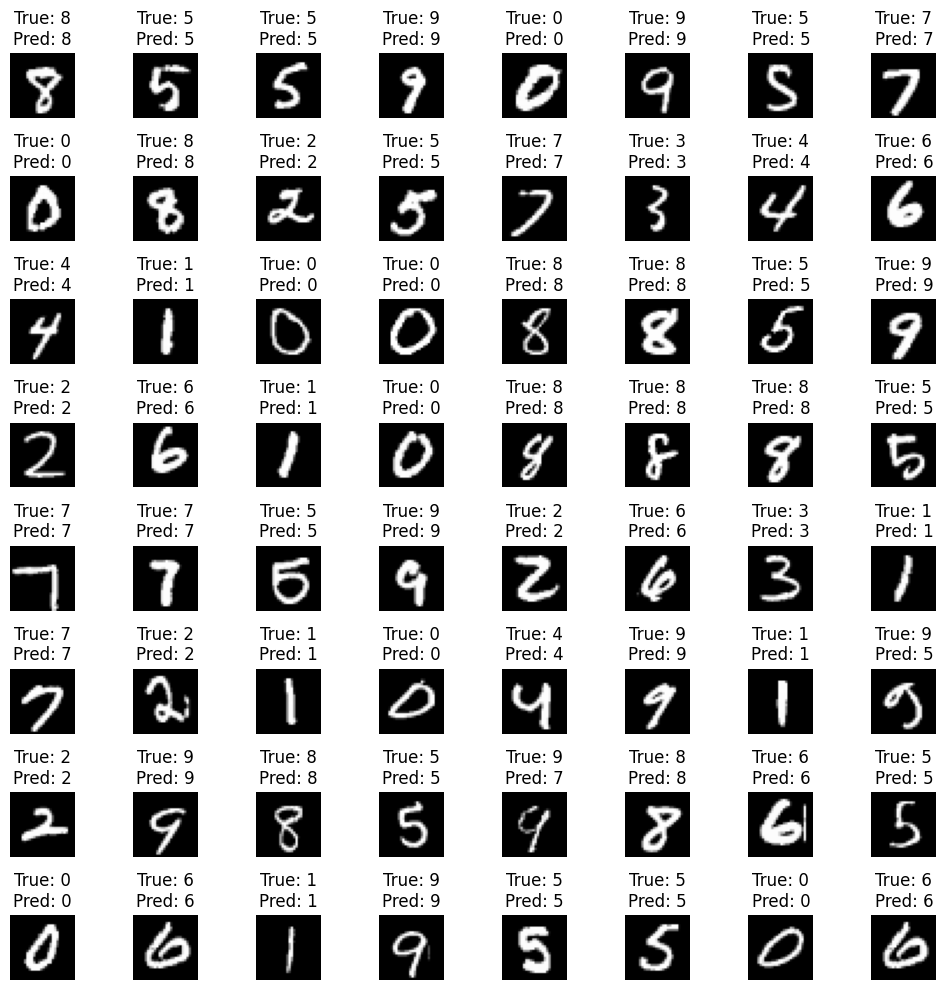

In [21]:
import matplotlib.pyplot as plt
import random

def image_display(images, true_labels, pred_labels, num_images):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(8, 8, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 64
idx_test = random.choices(range(10_000), k = num_images)

image_test = test_images[idx_test] / 255
label_test = test_labels[idx_test]
preds = infer(image_test)

image_display(image_test.reshape(-1, 28, 28), label_test, np.argmax(preds, axis = 1), num_images)
